# Froggification

How to plot some frogs. Inspired by https://turtletoy.net/turtle/90a99d3469

Uses drawings from https://github.com/googlecreativelab/quickdraw-dataset

![result](froggification.jpg "result")

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import imageio
import struct
from struct import unpack

In [2]:
# https://github.com/fogleman/axi
# https://github.com/secnot/rectpack
import axi
import rectpack

In [3]:
# Load the binary data
def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

In [4]:
# Get your frogs (or whatever you fancy) from here:
# https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/binary
frogs = list(unpack_drawings('full_binary_frog.bin'))

In [5]:
# transpose paths so axi likes them
def to_lines(img):
    return [[(x, y) for (x, y) in zip(path[0], path[1])] for path in img]

In [6]:
# check we have enough frogs
len(frogs)

159047

In [7]:
# looking good, pick some to plot!
n = 20
froggies = random.sample(frogs, n*n)

In [8]:
# make them into axi Drawings, and scale them so we have a bit more variety
fds = [axi.Drawing(to_lines(f['image'])).scale(random.uniform(0.2, 2)) for f in froggies]

In [9]:
# Use rectpack to binpack the frogs into a nice rectangle
p = rectpack.newPacker(mode=rectpack.PackingMode.Offline, rotation=False, sort_algo=rectpack.SORT_NONE)
p.add_bin(256 * n, 256 * n)
for i, f in enumerate(fds):
    p.add_rect(f.width * 1.05, f.height * 1.05, i)
p.pack()
rl = p.rect_list()

In [10]:
# optional: load a 256x256 mask so our output is not just a boring square
if True:
    mask = imageio.imread('frogmask.png')
    mask = mask[:, :, 0] != 255
    mask = mask.transpose()
else:
    mask = None

In [11]:
# plot our frogs!
BOUNDS = axi.A3_BOUNDS
d = axi.Drawing()

for (binid, x, y, h, w, idx) in rl:
    if mask is not None and mask[int(x/n)][int(y/n)]:
        d.add(fds[idx].translate(x, y))

d = d.scale_to_fit(8, 8)
d.dump('frogs.axi')
d.dump_svg('frogs.svg')
d.render(bounds=BOUNDS).write_to_png('frogs.png')

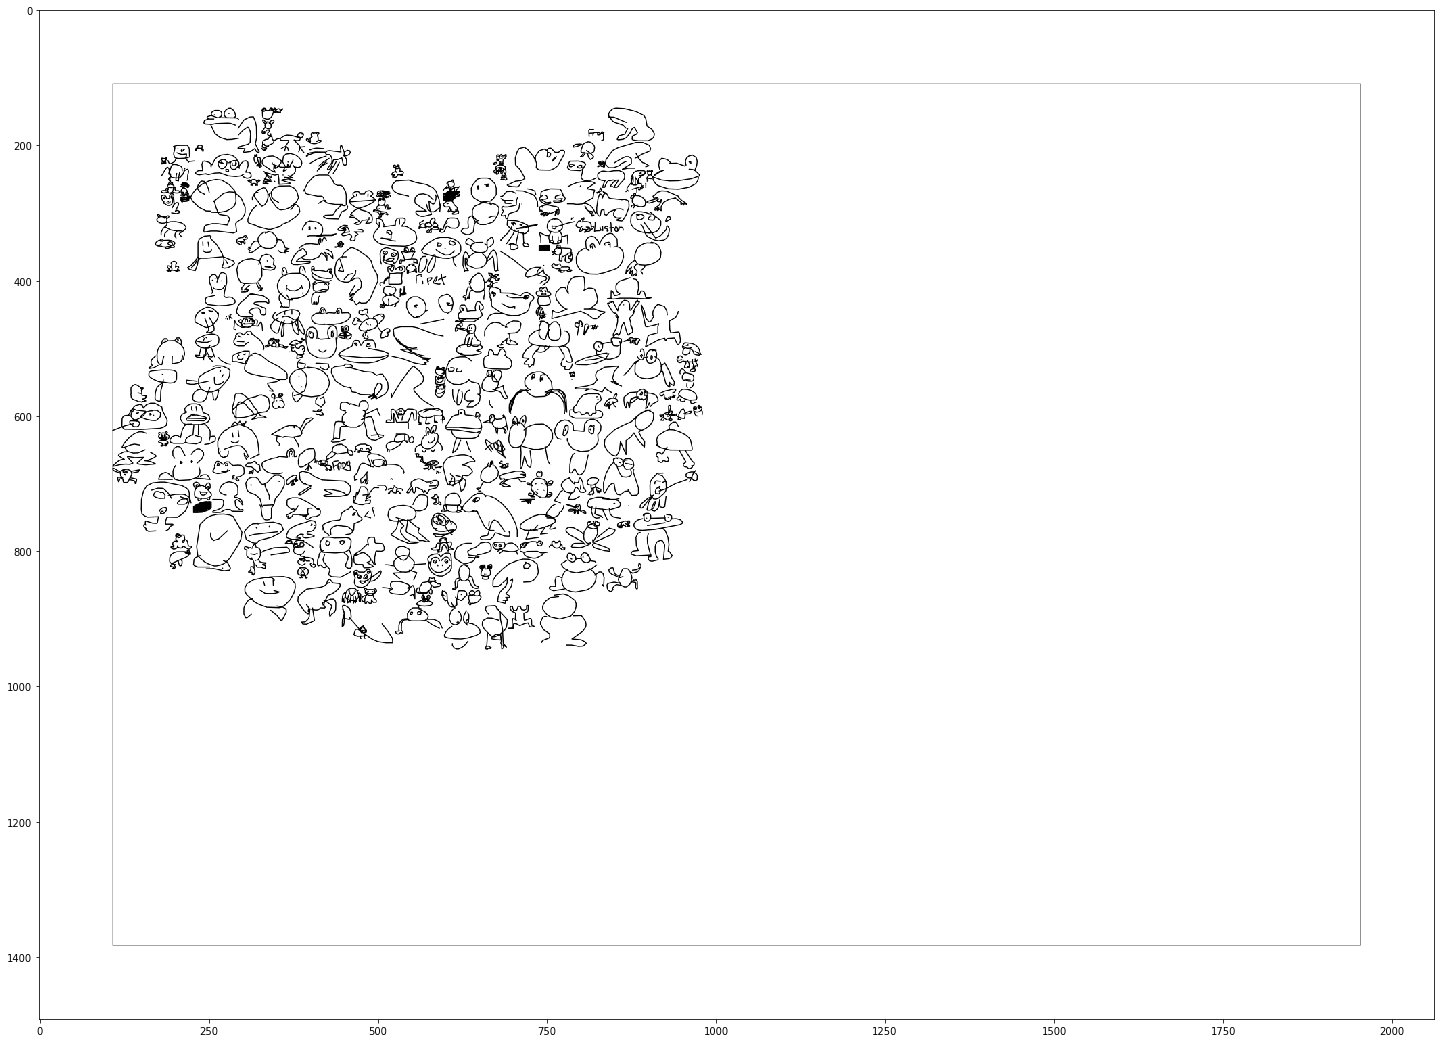

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 25
image = mpimg.imread("frogs.png")
plt.imshow(image)
plt.show()